# Preliminaries
<hr style="border:2px solid gray"></hr>

### Import libraries
Import the appropriate libraries to be used throughout this notebook.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools as it
import time

### Train, test, verification split
Defines a function that splits the data into three groups, depending on the input parameters.

In [2]:
def train_test_verification_split(X, y, split_tr, split_v, split_te):    
    # define the data split
    total_count = X.shape[0]
    train_split = int(total_count * split_tr)
    ver_split = int(total_count * split_v) + train_split
    test_split = int(total_count * split_te) + ver_split
    return X[:train_split], y[:train_split], X[train_split:ver_split], y[train_split:ver_split], X[ver_split:test_split], y[ver_split:test_split]

### Utility class

This function computes the root mean squared error, given the actual data and the predicted data of the target variable.

In [3]:
class util():
    @staticmethod
    def score(actual, prediction):
        return math.sqrt(np.mean((actual - prediction)**2))
    
    @staticmethod
    def squared_error(actual, prediction):
        return np.sum((actual - prediction)**2)
    
    @staticmethod
    def mean_absolute_error(actual, prediction):
        return np.sum(np.fabs(actual - prediction)) / actual.shape[0]

# Read the data
<hr style="border:2px solid gray"></hr>
If you run the toy problem codeblock or the SARCOS dataset codeblock, then it will use that data for the rest of the notebook. Therefore, run the codeblock with the data you want to use, and not the codeblock that you don't want to use.

### Toy problem
Run the code block below to work with the toy problem throughout the rest of this notebook.

Using the toy problem...
Splitting data...


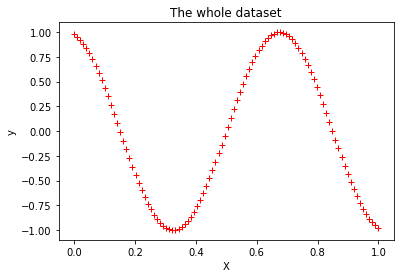

In [4]:
toy_problem = True
print("Using the toy problem...")
f = lambda x: np.sin(0.9*x)
#f = lambda x: np.exp(x)
#f = lambda x: 2*x+4

X_data = np.linspace(-5,5,100).reshape(-1,1)
y_data = f(X_data)

df = pd.DataFrame(np.c_[X_data, y_data])
# shuffle data
df = df.sample(frac=1).reset_index(drop=True)

# split off the target variable
X, y = df.iloc[:,:-1], df.iloc[:,-1]
# normalise data
X = (X - X.min()) / (X.max() - X.min())

print("Splitting data...")
X_train, y_train, X_ver, y_ver, X_test, y_test = train_test_verification_split(X, y, 0.6, 0.2, 0.2)

plt.plot(X, y, "r+")
plt.title("The whole dataset")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

### SARCOS dataset
Run the code block below to work with the SARCOS dataset throughout the rest of this notebook.

In [13]:
toy_problem = False
print("Using the SARCOS dataset...")
# read in csv file
df = pd.read_csv("sarcos_inv.csv", header=None)
# shuffle data
df = df.sample(frac=1).reset_index(drop=True)

# split off the target variable
X, y = df.iloc[:,:-1], df.iloc[:,-1]
# normalise data
X = (X - X.min()) / (X.max() - X.min())

print("Splitting data...")
X_train, y_train, X_ver, y_ver, X_test, y_test = train_test_verification_split(X, y, 0.6, 0.2, 0.2)

Using the SARCOS dataset...
Splitting data...


# Random Forest regression
<hr style="border:2px solid gray"></hr>

This is my implementation of random forest regression.

#### Decision Tree Class
A DecisionTree class is defined, objects of this class are created in the RandomForest Class below. This DecisionTree class allows for the creation of each decision tree.

In [14]:
class DecisionTree():
    def __init__(self, x, y, feature_split, min_leaf, depth):
        self.x = x
        self.y = y
        self.min_leaf = min_leaf
        self.depth = depth
        self.row_count = x.shape[0]
        self.idxs = np.array(range(self.row_count))
        self.feature_split = np.random.choice(range(x.shape[1]), size=feature_split.shape[0], replace=False)
        self.val = np.mean(y.values[self.idxs])
        self.score = np.inf

        self.left_tree = None
        self.right_tree = None
        self.split_feature = None
        self.split_val = None

        self.find_feature_split()

    def find_feature_split(self):
        for fea in self.feature_split:
            self.check_feature_split(fea)

        if self.is_leaf:
            return

        x = self.split_col

        lhs = np.nonzero(x <= self.split_val)[0]
        rhs = np.nonzero(x > self.split_val)[0]

        self.left_tree = DecisionTree(self.x.iloc[lhs], self.y.iloc[lhs], self.feature_split, self.min_leaf, self.depth - 1)
        self.right_tree = DecisionTree(self.x.iloc[rhs], self.y.iloc[rhs], self.feature_split, self.min_leaf, self.depth - 1)

    def check_feature_split(self, feature):
        x = self.x.values[self.idxs, feature]
        y = self.y.values[self.idxs]

        sorted_idx = np.argsort(x)
        sorted_x = x[sorted_idx]
        sorted_y = y[sorted_idx]

        rhs_count = self.row_count
        rhs_sum = np.sum(sorted_y)
        rhs_square_sum = np.sum(sorted_y ** 2)

        lhs_count = 0
        lhs_sum = 0.0
        lhs_square_sum = 0.0

        for i in range(0, self.row_count - self.min_leaf):
            x_i = sorted_x[i]
            y_i = sorted_y[i]

            lhs_count += 1
            rhs_count -= 1

            lhs_sum += y_i
            rhs_sum -= y_i

            lhs_square_sum += y_i ** 2
            rhs_square_sum -= y_i ** 2

            if i < self.min_leaf - 1 or x_i == sorted_x[i + 1]:
                continue

            lhs_std = self.std(lhs_count, lhs_sum, lhs_square_sum)
            rhs_std = self.std(rhs_count, rhs_sum, rhs_square_sum)
            curr_score = lhs_std * lhs_count + rhs_std * rhs_count

            if curr_score < self.score:
                self.split_feature = feature
                self.score = curr_score
                self.split_val = x_i

    def std(self, count, sum_val, square_sum):
        return math.sqrt(math.fabs((square_sum / count) - (sum_val / count) ** 2))

    @property
    def split_name(self):
        return self.x.columns[self.split_feature]

    @property
    def split_col(self):
        return self.x.values[self.idxs, self.split_feature]

    @property
    def is_leaf(self):
        return self.score == np.inf or self.depth <= 0

    def predict(self, x):
        rows = [self.predict_row(x_i[1]) for x_i in x.iterrows()]
        return np.array(rows)

    def predict_row(self, x_i):
        if self.is_leaf:
            return self.val

        if x_i[self.split_feature] <= self.split_val:
            return self.left_tree.predict_row(x_i)
        else:
            return self.right_tree.predict_row(x_i)


#### Random Forest Class
The RandomForest class is defined, it has methods to create the tree and fit the model to the training data, and make predictions with the test data.

In [15]:
class RandomForest():
    def __init__(self, n_estimators, feature_split, sample_size, min_leaf=1, depth=10):
        self.n_estimators = n_estimators
        self.feature_split = np.random.randint(0, int(feature_split), size=int(feature_split))
        self.sample_size = sample_size
        self.min_leaf = min_leaf
        self.depth = depth
        self.trees = None

    def create_tree(self, x, y):
        idxs = np.random.randint(y.shape[0], size=self.sample_size)
        return DecisionTree(x.iloc[idxs], y.iloc[idxs], self.feature_split, self.min_leaf, self.depth)

    def fit(self, x, y):
        self.trees = None
        self.trees = [self.create_tree(x, y) for i in range(self.n_estimators)]

    def predict(self, x):
        tree_predictions = [tree.predict(x) for tree in self.trees]
        prediction = np.mean(tree_predictions, axis=0)
        return prediction


#### Perform Random Forest Regression
This function creates an object of the RandomForest class, the fit method is then called to train the model using the training data. The predict method is then called using the test data as the argument, it returns the predicted data using the test data.

In [16]:
def perform_rf(X_, y_, number_of_features):
    print("number of features: ", number_of_features)
    
    # train the model
    rf_regressor = RandomForest(n_estimators=20, feature_split=number_of_features, sample_size=X_train.shape[0], min_leaf=1, depth=10)
    rf_regressor.fit(X_train, y_train)
    
    # predict
    y_pred = rf_regressor.predict(X_)

    # compute rmse
    rmse = util.score(y_.values.flatten(), y_pred)
    
    print("The RMSE is {}".format(rmse))
    
    return rmse, y_pred

#### Hyperparameter Tuning
The hyperparamters are tuned using the verification set. Find the best hyperparameters.

In [17]:
def get_best_hyperparameters(feature_sel):
    rmse_arr = []
    elapsed_time_arr = []
    for number_of_features in feature_sel:
        start_time = time.time()
        rmse, _ = perform_rf(X_ver, y_ver, number_of_features)
        elapsed_time = time.time() - start_time
        print("Time taken: ", elapsed_time,"\n")
        elapsed_time_arr.append(elapsed_time)
        rmse_arr.append(rmse)
        
    return feature_sel[np.argmin(rmse_arr)], rmse_arr, elapsed_time_arr

In [18]:
print("This will take a little...")
print("Finding the best hyperparameters...")
#feature_sel = [int(np.sqrt(X_train.shape[1])), 10, 12]
if toy_problem:
    feature_sel = [0,1]
else:
    feature_sel = [12,13,15,16,17]
# tune the hyperparameters with the verification set
best_feature_sel, rmse_arr, elapsed_time_arr, = get_best_hyperparameters(feature_sel)

This will take a little...
Finding the best hyperparameters...
number of features:  12
The RMSE is 4.8370721911272465
Time taken:  303.8464469909668 

number of features:  13
The RMSE is 4.744347097688439
Time taken:  319.4384961128235 

number of features:  15
The RMSE is 4.713045228911015
Time taken:  422.95060682296753 

number of features:  16
The RMSE is 4.68548567647365
Time taken:  487.0418133735657 

number of features:  17
The RMSE is 4.738749177535215
Time taken:  453.7889051437378 



#### Use the trained model to predict with the test data
The model has been trained with the data above, now uses the tuned hyperparameters that were calcualted above, and uses that to predict with the test data.

In [19]:
print("This will take about 10 minutes...")
print("\nPerforming the trained model on the test set with the tuned hyperparameters...")
start_time = time.time()
# predict on the test set
rmse_test, y_pred = perform_rf(X_test, y_test, best_feature_sel)
elapsed_time = time.time() - start_time

print("Time taken: ", elapsed_time)

This will take about 10 minutes...

Performing the trained model on the test set with the tuned hyperparameters...
number of features:  16
The RMSE is 4.703151409997485
Time taken:  392.85632705688477


#### Plot the the number of features
Plot the number of features against the RMSE and the time taken, in order to find the optimal number of features.

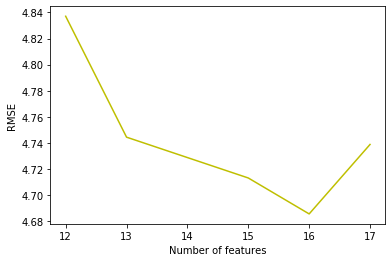

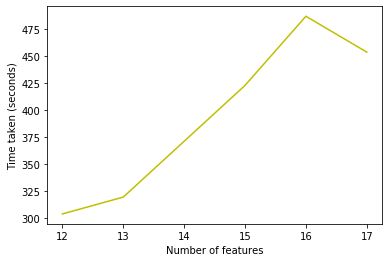

In [20]:
plt.plot(feature_sel, rmse_arr, "y-")
plt.xlabel("Number of features")
plt.ylabel("RMSE")
plt.show()

plt.plot(feature_sel, elapsed_time_arr, "y-")
plt.ylabel("Time taken (seconds)")
plt.xlabel("Number of features")
plt.show()

#### Plot to check that Random Forest works for the toy problem
Given that the toy problem is being used and not the SARCOS dataset, then this codeblock plots various graphs comparing predicted data to actual data.

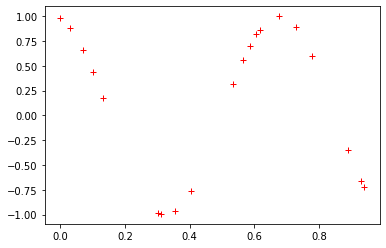

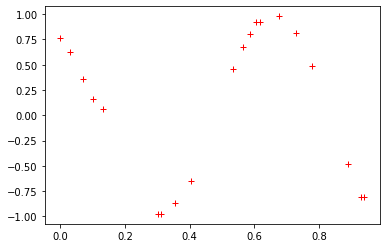

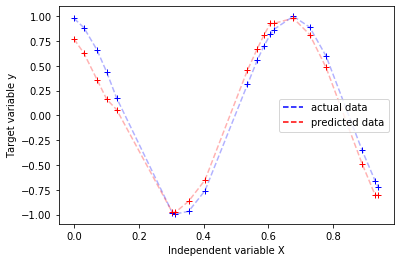

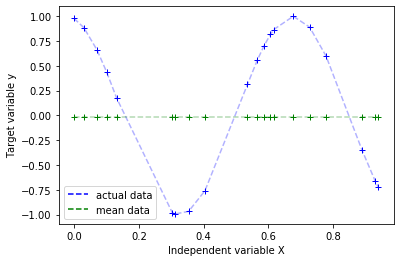

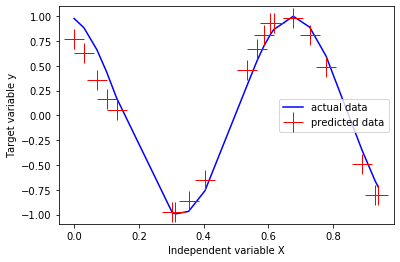

In [12]:
if toy_problem:

    plt.plot(X_test, y_test, "r+")
    plt.show()

    plt.plot(X_test, y_pred, "r+")
    plt.show()

    plt.plot(np.sort(X_test.values.flatten()), y_test.values[np.argsort(X_test.values.flatten())], "b+")
    plt.plot(np.sort(X_test.values.flatten()), y_test.values[np.argsort(X_test.values.flatten())], "b--", alpha=0.3, label="actual data")
    plt.plot(X_test, y_pred, "r+")
    plt.plot(np.sort(X_test.values.flatten()), y_pred[np.argsort(X_test.values.flatten())], "r--", alpha=0.3, label="predicted data")
    plt.xlabel("Independent variable X")
    plt.ylabel("Target variable y")
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.show()

    plt.plot(np.sort(X_test.values.flatten()), y_test.values[np.argsort(X_test.values.flatten())], "b+")
    plt.plot(np.sort(X_test.values.flatten()), y_test.values[np.argsort(X_test.values.flatten())], "b--", alpha=0.3, label="actual data")
    plt.plot(X_test, np.full(y_test.shape[0], np.mean(y_train.values)), "g+")
    plt.plot(np.sort(X_test.values.flatten()), np.full(y_test.shape[0], np.mean(y_train.values)), "g--", alpha=0.3, label="mean data")
    plt.xlabel("Independent variable X")
    plt.ylabel("Target variable y")
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.show()


    plt.plot(np.sort(X_test.values.flatten()), y_test.values[np.argsort(X_test.values.flatten())], "b-", label="actual data")
    plt.plot(X_test, y_pred, "r+", markersize=20, label="predicted data")
    plt.xlabel("Independent variable X")
    plt.ylabel("Target variable y")
    plt.legend()
    plt.show()